In [285]:
import numpy as np
import pandas as pd
from typing import List, Tuple
from scipy.stats import probplot, ks_2samp,shapiro,kstest
from sklearn.model_selection import cross_val_score,train_test_split
import matplotlib
import umap
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score,roc_curve
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold
%matplotlib inline
%config inlinebackend.figure_format = 'svg'

In [286]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

Задание 1: сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (
TransactionID
), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.

In [309]:
train = pd.read_csv('assignment_2_train.csv')
test = pd.read_csv('assignment_2_test.csv')
train

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,3166995,0,3958217,39.00,W,1877,310.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179996,3166996,0,3958237,59.95,W,10075,514.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179997,3166997,0,3958241,34.00,W,6053,122.0,150.0,mastercard,195.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179998,3166998,0,3958260,59.00,W,7726,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [451]:
X=train.drop('isFraud', axis=1)
y=train['isFraud']
X_lb=test.drop('isFraud', axis=1)
y_lb=test['isFraud']

In [464]:
cat=X.select_dtypes(include='object').columns.to_list()
num=X.select_dtypes(exclude='object').columns.to_list()
X_cat=X.copy()
X_cat[cat]=X_cat.select_dtypes(include='object').astype('category')
X_lb[cat]=X_lb.select_dtypes(include='object').astype('category')
X_train, X_val, y_train, y_val = train_test_split(X_cat, y, test_size=0.25, random_state=101)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)


In [290]:
m_lgb_2= lgb.LGBMClassifier(n_estimators=50)
m_lgb_2.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='auc',
    early_stopping_rounds=10,
    verbose=20)

Training until validation scores don't improve for 10 rounds
[20]	training's auc: 0.919864	training's binary_logloss: 0.0633921	valid_1's auc: 0.877982	valid_1's binary_logloss: 0.102205
[40]	training's auc: 0.945544	training's binary_logloss: 0.0527928	valid_1's auc: 0.891927	valid_1's binary_logloss: 0.0953291
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.953273	training's binary_logloss: 0.0495205	valid_1's auc: 0.896147	valid_1's binary_logloss: 0.0940025


LGBMClassifier(n_estimators=50)

In [291]:
pred_train=m_lgb_2.predict_proba(X_train)[:,1]
pred_val=m_lgb_2.predict_proba(X_val)[:,1]
pred_lb=m_lgb_2.predict_proba(X_lb)[:,1]

roc_auc_train = roc_auc_score(y_train,pred_train)
roc_auc_val = roc_auc_score(y_val,pred_val)
roc_auc_lb = roc_auc_score(y_lb,pred_lb)

print(f'roc_auc_train : {round(roc_auc_train,2)}')
print(f'roc_auc_val : {round(roc_auc_val,2)}')
print(f'roc_auc_lb : {round(roc_auc_lb,2)}')

roc_auc_train : 0.95
roc_auc_val : 0.9
roc_auc_lb : 0.86


In [292]:
# Налицо переобучение

Задание 2: сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.

In [293]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=101)
X_train = X_train.reset_index(drop=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [294]:
m_lgb_3= lgb.LGBMClassifier(n_estimators=50)
m_lgb_3.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='auc',
    early_stopping_rounds=10,
    verbose=20)

Training until validation scores don't improve for 10 rounds
[20]	training's auc: 0.92549	training's binary_logloss: 0.0620453	valid_1's auc: 0.872664	valid_1's binary_logloss: 0.101817
[40]	training's auc: 0.953842	training's binary_logloss: 0.0505961	valid_1's auc: 0.889415	valid_1's binary_logloss: 0.095807
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.962942	training's binary_logloss: 0.0468695	valid_1's auc: 0.892308	valid_1's binary_logloss: 0.0944726


LGBMClassifier(n_estimators=50)

In [295]:
pred_train=m_lgb_3.predict_proba(X_train)[:,1]
pred_val=m_lgb_3.predict_proba(X_val)[:,1]
pred_test=m_lgb_3.predict_proba(X_test)[:,1]
pred_lb=m_lgb_3.predict_proba(X_lb)[:,1]

roc_auc_train = roc_auc_score(y_train,pred_train)
roc_auc_val = roc_auc_score(y_val,pred_val)
roc_auc_test = roc_auc_score(y_test,pred_test)
roc_auc_lb = roc_auc_score(y_lb,pred_lb)

print(f'roc_auc_train : {round(roc_auc_train,2)}')
print(f'roc_auc_val : {round(roc_auc_val,2)}')
print(f'roc_auc_test : {round(roc_auc_test,2)}')
print(f'roc_auc_lb : {round(roc_auc_lb,2)}')

roc_auc_train : 0.96
roc_auc_val : 0.89
roc_auc_test : 0.92
roc_auc_lb : 0.87


Задание 3: построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.

In [296]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
 
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
   
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:

    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [297]:
np.random.seed(101)
scores_train = create_bootstrap_metrics(y_train, m_lgb_3.predict_proba(X_train)[:,1], roc_auc_score)
scores_val = create_bootstrap_metrics(y_val, m_lgb_3.predict_proba(X_val)[:,1], roc_auc_score)
scores_test= create_bootstrap_metrics(y_test, m_lgb_3.predict_proba(X_test)[:,1], roc_auc_score)
scores_lb= create_bootstrap_metrics(y_lb, m_lgb_3.predict_proba(X_lb)[:,1], roc_auc_score)

confidence_int_train = calculate_confidence_interval(scores_train)
confidence_int_val = calculate_confidence_interval(scores_val)
confidence_int_test = calculate_confidence_interval(scores_test)
confidence_int_lb = calculate_confidence_interval(scores_lb)

print(f'confidence_int_train : {list(map(lambda x: round(x,3),confidence_int_train))}')
print(f'confidence_int_val : {list(map(lambda x: round(x,3),confidence_int_val))}')
print(f'confidence_int_test : {list(map(lambda x: round(x,3),confidence_int_test))}')
print(f'confidence_int_lb : {list(map(lambda x: round(x,3),confidence_int_lb))}')

confidence_int_train : [0.958, 0.967]
confidence_int_val : [0.882, 0.902]
confidence_int_test : [0.911, 0.931]
confidence_int_lb : [0.858, 0.872]


In [298]:
# Доверительные интервалы пересекаются только у val и test, что говорит о том, что распределения сильно отличаются,
# что свидетельствует о том, что алгоритм не очень хорошо улавливает общие закономерности.

Задание 4: выполнить Adversarial Validation, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из
assignment_2_test.csv
, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.

In [358]:
X_adv=pd.concat([X_train,X_lb])
X_adv.R_emaildomain=X_adv.R_emaildomain.astype('category')
X_adv.reset_index(drop=True, inplace=True)
y_adv = np.hstack(
    (np.ones(X_train.shape[0]), np.zeros(X_lb.shape[0])))

In [359]:
m_lgb_adv= lgb.LGBMClassifier(n_estimators=50)
m_lgb_adv.fit(
    X_adv, y_adv,
    eval_set=[(X_adv, y_adv)],
    eval_metric='auc',
    early_stopping_rounds=10,
    verbose=20)


Training until validation scores don't improve for 10 rounds
[20]	training's auc: 1	training's binary_logloss: 0.067019
[40]	training's auc: 1	training's binary_logloss: 0.00921145
Did not meet early stopping. Best iteration is:
[49]	training's auc: 1	training's binary_logloss: 0.00394179


LGBMClassifier(n_estimators=50)

In [360]:
cross_val_score(m_lgb_adv,X_adv,y_adv, scoring='roc_auc').mean()

0.999510024498775

In [302]:
# Алгоритм однозначно разделяет выборки

<AxesSubplot:title={'center':'Feature importance advance'}, xlabel='Feature importance', ylabel='Features'>

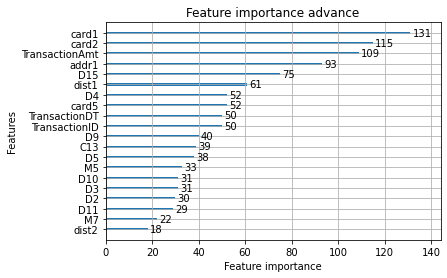

In [230]:
lgb.plot_importance(m_lgb_adv,max_num_features=20, title='Feature importance advance')


<AxesSubplot:title={'center':'Feature importance hold_out_2'}, xlabel='Feature importance', ylabel='Features'>

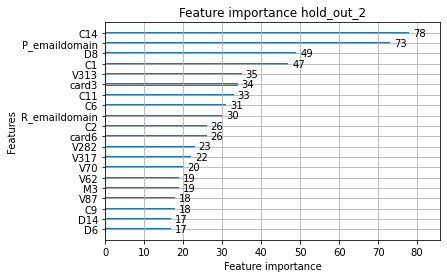

In [231]:
lgb.plot_importance(m_lgb_2,max_num_features=20,title='Feature importance hold_out_2')

In [232]:
# Очевидно, что те признаки, по которым идет разделение выборок, 
# они же являются ключевыми в обучении алгоритма hold_out_2.
# Удаление этих признаков, скорее всего, негативно скажется
# на предсказательной способности алгоритма. Проверим.

In [361]:
def feat_imp(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

In [362]:
feat_import=feat_imp(m_lgb_adv.feature_name_, m_lgb_adv.feature_importances_)
feat_diff = feat_import.feature[:200].values
feat_diff

array(['card2', 'card1', 'TransactionAmt', 'addr1', 'D15', 'dist1', 'D5',
       'TransactionID', 'TransactionDT', 'D4', 'card5', 'D3', 'D11', 'D9',
       'M5', 'D2', 'V307', 'D10', 'dist2', 'D1', 'V127', 'M7', 'C6',
       'V130', 'M9', 'C13', 'M6', 'M4', 'V48', 'C2', 'V35', 'V96', 'V314',
       'V282', 'V75', 'V221', 'V12', 'C9', 'D8', 'V131', 'V310', 'V50',
       'V124', 'V62', 'V29', 'M3', 'V53', 'V308', 'V20', 'V10', 'V315',
       'V36', 'V313', 'V312', 'V39', 'V261', 'D7', 'M8', 'V49', 'V100',
       'V56', 'C12', 'V76', 'V69', 'V59', 'C1', 'V291', 'V37', 'V317',
       'V5', 'V294', 'V38', 'V285', 'D6', 'V87', 'V129', 'V45', 'C14',
       'M2', 'C10', 'V13', 'V99', 'V70', 'V144', 'V136', 'V61', 'V287',
       'V270', 'V101', 'V139', 'V218', 'V54', 'V217', 'C5', 'V26', 'V102',
       'V85', 'V167', 'V203', 'V43', 'V6', 'V260', 'V306', 'V316', 'V11',
       'V91', 'V309', 'V242', 'V244', 'V227', 'V336', 'V228', 'V229',
       'V234', 'V243', 'V230', 'V241', 'V231', 'V240', 'V3

In [363]:
feat_import

,feature,feature_importance
0,card2,125
1,card1,120
2,TransactionAmt,111
3,addr1,107
4,D15,88
...,...,...
388,V122,0
389,V121,0
390,V120,0
391,V119,0


In [364]:
X_adv=pd.concat([X_train.drop(feat_diff,axis=1),X_lb.drop(feat_diff,axis=1)])
X_adv.R_emaildomain=X_adv.R_emaildomain.astype('category')
X_adv.reset_index(drop=True, inplace=True)
y_adv = np.hstack(
    (np.ones(X_train.shape[0]), np.zeros(X_lb.shape[0])))

In [365]:
m_lgb_adv= lgb.LGBMClassifier(n_estimators=50)
m_lgb_adv.fit(
    X_adv, y_adv,
    eval_set=[(X_adv, y_adv)],
    eval_metric='auc',
    early_stopping_rounds=10,
    verbose=20)


Training until validation scores don't improve for 10 rounds
[20]	training's auc: 0.795496	training's binary_logloss: 0.53952
[40]	training's auc: 0.803788	training's binary_logloss: 0.523788
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.80642	training's binary_logloss: 0.520328


LGBMClassifier(n_estimators=50)

In [366]:
cross_val_score(m_lgb_adv,X_adv,y_adv, scoring='roc_auc').mean()

0.7483646282264684

In [367]:
X_train_adv = X_train.drop(feat_diff,axis=1)
X_lb_adv = X_lb.drop(feat_diff,axis=1)
X_val_adv = X_val.drop(feat_diff,axis=1)

In [368]:
m_lgb_2= lgb.LGBMClassifier(n_estimators=50)
m_lgb_2.fit(
    X_train_adv, y_train,
    eval_set=[(X_train_adv, y_train), (X_val_adv, y_val)],
    eval_metric='auc',
    early_stopping_rounds=10,
    verbose=20)

Training until validation scores don't improve for 10 rounds
[20]	training's auc: 0.885823	training's binary_logloss: 0.0726889	valid_1's auc: 0.84408	valid_1's binary_logloss: 0.107508
[40]	training's auc: 0.902369	training's binary_logloss: 0.0660364	valid_1's auc: 0.856197	valid_1's binary_logloss: 0.103937
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.910111	training's binary_logloss: 0.0637665	valid_1's auc: 0.860063	valid_1's binary_logloss: 0.102732


LGBMClassifier(n_estimators=50)

In [369]:
pred_train=m_lgb_2.predict_proba(X_train_adv)[:,1]
pred_val=m_lgb_2.predict_proba(X_val_adv)[:,1]
pred_lb=m_lgb_2.predict_proba(X_lb_adv)[:,1]

roc_auc_train = roc_auc_score(y_train,pred_train)
roc_auc_val = roc_auc_score(y_val,pred_val)
roc_auc_lb = roc_auc_score(y_lb,pred_lb)

print(f'roc_auc_train : {round(roc_auc_train,2)}')
print(f'roc_auc_val : {round(roc_auc_val,2)}')
print(f'roc_auc_lb : {round(roc_auc_lb,2)}')

roc_auc_train : 0.91
roc_auc_val : 0.86
roc_auc_lb : 0.83


In [242]:
# Из имеющихся признаков сложно подобрать похожие, которые бы давали приемлемую итоговую метрику.
# Нужно каким-то образом модифицировать признаковое пространство.

Задание 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.

In [454]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy,
                          groups=None):
 
    estimators, fold_train_scores, fold_valid_scores, fold_lb_scores = [], [], [], []
    oof_predictions_val = np.zeros(X.shape[0])
    oof_predictions_lb = []

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y,groups=groups)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]
        

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict_proba(x_train)[:,1]
        y_valid_pred = estimator.predict_proba(x_valid)[:,1]
        y_lb_pred = estimator.predict_proba(X_lb)[:,1]
        
        
        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        fold_lb_scores.append(metric(y_lb, y_lb_pred))
        oof_predictions_val[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}, "
            f"lb-score = {round(fold_lb_scores[fold_number], 4)}"
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score_val = metric(y, oof_predictions_val)
#     oof_score_lb = np.mean(fold_lb_scores)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"CV-results lb: {round(np.mean(fold_lb_scores), 4)} +/- {round(np.std(fold_lb_scores), 3)}")        
    print(f"OOF-score_val = {round(oof_score_val, 4)}")
#     print(f"OOF-score_lb = {round(oof_score_lb, 4)}")

    return estimators, oof_score_val, fold_train_scores, fold_valid_scores,fold_lb_scores, oof_predictions_val, oof_predictions_lb

In [455]:
m_lgb = lgb.LGBMClassifier(n_estimators=50)
cv_strategy = KFold(n_splits=5, random_state=1)

estimators, oof_score, fold_train_scores, fold_valid_scores,fold_lb_scores, oof_predictions_val,oof_predictions_lb  = make_cross_validation(
    X_lgbm_cat, y, m_lgb, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 144000, valid-observations = 36000
train-score = 0.9546, valid-score = 0.896, lb-score = 0.8616
Fold: 2, train-observations = 144000, valid-observations = 36000
train-score = 0.9536, valid-score = 0.9092, lb-score = 0.8637
Fold: 3, train-observations = 144000, valid-observations = 36000
train-score = 0.9533, valid-score = 0.9094, lb-score = 0.8632
Fold: 4, train-observations = 144000, valid-observations = 36000
train-score = 0.951, valid-score = 0.9029, lb-score = 0.8613
Fold: 5, train-observations = 144000, valid-observations = 36000
train-score = 0.9529, valid-score = 0.9006, lb-score = 0.8636
CV-results train: 0.9531 +/- 0.001
CV-results valid: 0.9036 +/- 0.005
CV-results lb: 0.8627 +/- 0.001
OOF-score_val = 0.903


In [ ]:
# Валидация стабильна на всех выборках, отклонение менее 1%.

Задание 6 (опциональное): сделать Hold-Out валидацию по времени (
TransactionDT
), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. Сделать выводы.

In [352]:


train_DT=train.sort_values('TransactionDT')

X=train_DT.drop('isFraud', axis=1)
y=train_DT['isFraud']
X_lb=test.drop('isFraud', axis=1)
y_lb=test['isFraud']

In [353]:

X[cat]=X[cat].select_dtypes(include='object').astype('category')
X_lb[cat]=X_lb.select_dtypes(include='object').astype('category')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25,shuffle=False, random_state=101)
X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)
y_val.reset_index(inplace=True, drop=True)


In [354]:
m_lgb_t= lgb.LGBMClassifier(n_estimators=50,objective = 'binary',boosting_type="gbdt")
m_lgb_t.fit(
X_train, y_train,
eval_set=[(X_train, y_train), (X_val, y_val)],
eval_metric='auc',
early_stopping_rounds=10,
verbose=20)

Training until validation scores don't improve for 10 rounds
[20]	training's auc: 0.919864	training's binary_logloss: 0.0633921	valid_1's auc: 0.877982	valid_1's binary_logloss: 0.102205
[40]	training's auc: 0.945544	training's binary_logloss: 0.0527928	valid_1's auc: 0.891927	valid_1's binary_logloss: 0.0953291
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.953273	training's binary_logloss: 0.0495205	valid_1's auc: 0.896147	valid_1's binary_logloss: 0.0940025


LGBMClassifier(n_estimators=50, objective='binary')

In [355]:
pred_train=m_lgb_t.predict_proba(X_train)[:,1]
pred_val=m_lgb_t.predict_proba(X_val)[:,1]
pred_lb=m_lgb_t.predict_proba(X_lb)[:,1]

roc_auc_train = roc_auc_score(y_train,pred_train)
roc_auc_val = roc_auc_score(y_val,pred_val)
roc_auc_lb = roc_auc_score(y_lb,pred_lb)

print(f'roc_auc_train : {round(roc_auc_train,2)}')
print(f'roc_auc_val : {round(roc_auc_val,2)}')
print(f'roc_auc_lb : {round(roc_auc_lb,2)}')

roc_auc_train : 0.95
roc_auc_val : 0.9
roc_auc_lb : 0.86


In [266]:
# Ничего особенного

Задание 7 (совсем опциональное): в данном наборе данных у нас есть ID-транзакции (
TransactionID
) и время транзакции (
TransactionDT
), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (
GroupKFold
).

In [211]:
# Признаками, несущими в себе персонализированную информацию, являются признаки группы card, 
# хотя я не знаю точно,что они означают. Попробуем выделить клиентов (или группы клиентов)
# на основе признака card1

In [465]:
m_lgb_ind= lgb.LGBMClassifier(n_estimators=50,objective = 'binary',boosting_type="gbdt")
cv_strategy = GroupKFold(n_splits=5)
groups=X['card1']
estimators, oof_score, fold_train_scores, fold_valid_scores,fold_lb_scores, oof_predictions_val,oof_predictions_lb  = make_cross_validation(
    X_cat, y, m_lgb_ind,roc_auc_score,cv_strategy,groups)

Fold: 1, train-observations = 144000, valid-observations = 36000
train-score = 0.9534, valid-score = 0.8601, lb-score = 0.8619
Fold: 2, train-observations = 144000, valid-observations = 36000
train-score = 0.9565, valid-score = 0.875, lb-score = 0.8593
Fold: 3, train-observations = 144000, valid-observations = 36000
train-score = 0.957, valid-score = 0.8981, lb-score = 0.8555
Fold: 4, train-observations = 144000, valid-observations = 36000
train-score = 0.9527, valid-score = 0.911, lb-score = 0.8624
Fold: 5, train-observations = 144000, valid-observations = 36000
train-score = 0.9549, valid-score = 0.8635, lb-score = 0.8668
CV-results train: 0.9549 +/- 0.002
CV-results valid: 0.8815 +/- 0.02
CV-results lb: 0.8612 +/- 0.004
OOF-score_val = 0.8858


In [466]:
# Значимого улучшения модели не наблюдается. 
# Можно рассмотреть в качестве группового комбинацию признаков группы card и R_emaildomain